In [1]:
import joblib, os, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
DATA_DIR = "../data/processed"   # adjust path if notebook location differs
train = pd.read_csv(os.path.join(DATA_DIR, "processed_train.csv"))
test  = pd.read_csv(os.path.join(DATA_DIR, "processed_test.csv"))
feature_cols = [c for c in train.columns if c != 'label']
X_train = train[feature_cols].values
y_train = train['label'].values
X_test = test[feature_cols].values
y_test = test['label'].values

scale and encode

In [2]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(DATA_DIR, "scaler_used.save"))
# if labels are strings:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
joblib.dump(le, os.path.join(DATA_DIR, "label_encoder.save"))

['../data/processed\\label_encoder.save']

In [3]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_s, y_train_enc)
pred = rf.predict(X_test_s)
print(classification_report(y_test_enc, pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test_enc, rf.predict_proba(X_test_s)[:,1]))
joblib.dump(rf, os.path.join(DATA_DIR, "rf_model.save"))

              precision    recall  f1-score   support

           0     0.9960    0.9983    0.9972    111093
           1     0.9995    0.9990    0.9993    420983

    accuracy                         0.9988    532076
   macro avg     0.9978    0.9986    0.9982    532076
weighted avg     0.9988    0.9988    0.9988    532076

ROC AUC: 0.9999058834862768


['../data/processed\\rf_model.save']

Matplotlib is building the font cache; this may take a moment.


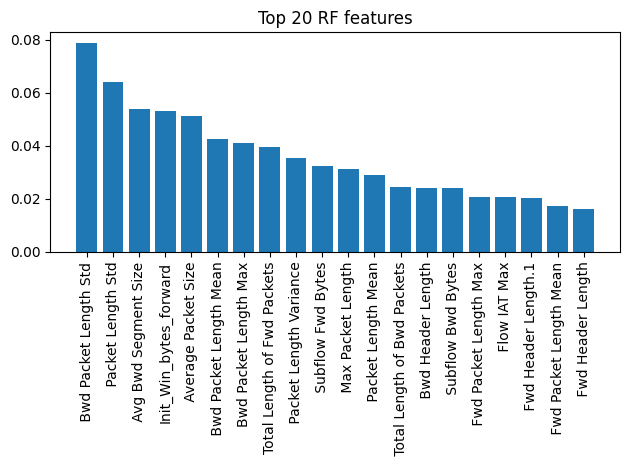

In [5]:
import matplotlib.pyplot as plt, numpy as np
imp = rf.feature_importances_
idx = np.argsort(imp)[::-1][:20]
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_cols[i] for i in idx], rotation=90)
plt.title("Top 20 RF features")
plt.tight_layout()
plt.show()

In [12]:
import joblib, os

DATA_DIR = "../data/processed"

joblib.dump(rf, os.path.join(DATA_DIR, "rf_model.save"))
joblib.dump(scaler, os.path.join(DATA_DIR, "scaler_used.save"))
joblib.dump(le, os.path.join(DATA_DIR, "label_encoder.save"))
print("✅ RF model and preprocessors saved.")

✅ RF model and preprocessors saved.


xgboost gpu

[0]	train-auc:0.99406	val-auc:0.99419
[10]	train-auc:0.99873	val-auc:0.99886
[20]	train-auc:0.99931	val-auc:0.99933
[30]	train-auc:0.99952	val-auc:0.99948
[40]	train-auc:0.99967	val-auc:0.99962
[50]	train-auc:0.99974	val-auc:0.99970
[60]	train-auc:0.99980	val-auc:0.99975
[70]	train-auc:0.99983	val-auc:0.99979
[80]	train-auc:0.99987	val-auc:0.99984
[90]	train-auc:0.99990	val-auc:0.99987
[99]	train-auc:0.99991	val-auc:0.99989
Training time: 55.9s

Classification report (on full test):
              precision    recall  f1-score   support

           0     0.9955    0.9973    0.9964    111093
           1     0.9993    0.9988    0.9990    420983

    accuracy                         0.9985    532076
   macro avg     0.9974    0.9980    0.9977    532076
weighted avg     0.9985    0.9985    0.9985    532076

ROC AUC (full test): 0.9999148013818878


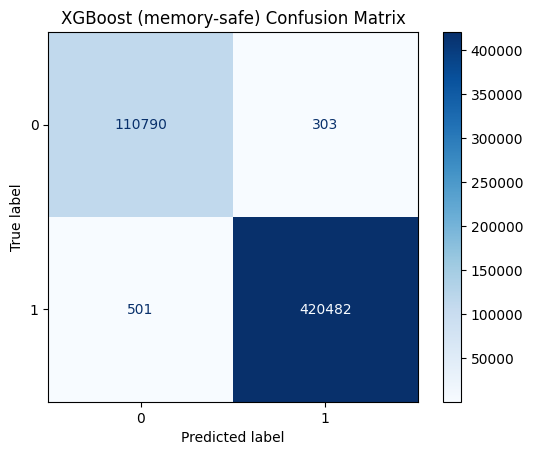

Model saved to: ../data/processed\xgb_model_memory_safe.json


In [11]:
# Memory-safe XGBoost training (sampled validation + lighter params)
import time, os
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def train_xgb_memory_safe(X_train, y_train, X_test, y_test, data_dir,
                          val_size=50000, num_round=100, max_depth=6):
    # shuffle indices to sample validation
    rng = np.random.RandomState(42)
    test_idx = rng.choice(len(X_test), size=min(val_size, len(X_test)), replace=False)
    X_val = X_test[test_idx]
    y_val = y_test[test_idx]
    # optional: use smaller train sample for tuning:
    # train_idx = rng.choice(len(X_train), size=int(0.6*len(X_train)), replace=False)
    # X_train_small, y_train_small = X_train[train_idx], y_train[train_idx]
    # But here we train on full train set

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "max_depth": max_depth,
        "eta": 0.1,
        "subsample": 0.6,
        "colsample_bytree": 0.6,
        "verbosity": 1,
        "max_bin": 64,
        "nthread": 6   # set to number of cores you want to use
    }

    evals = [(dtrain, "train"), (dval, "val")]
    start = time.time()
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        early_stopping_rounds=10,
        verbose_eval=10
    )
    print(f"Training time: {time.time() - start:.1f}s")

    # Evaluate on full test set in streaming: predict in chunks to avoid building a giant array
    def predict_in_chunks(model, X, chunk_size=200000):
        probs = []
        for i in range(0, X.shape[0], chunk_size):
            chunk = X[i:i+chunk_size]
            probs.append(model.predict(xgb.DMatrix(chunk)))
        return np.concatenate(probs)

    y_prob = predict_in_chunks(model, X_test, chunk_size=200000)
    y_pred = (y_prob >= 0.5).astype(int)

    print("\nClassification report (on full test):")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC (full test):", roc_auc_score(y_test, y_prob))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
    plt.title("XGBoost (memory-safe) Confusion Matrix")
    plt.show()

    out_path = os.path.join(data_dir, "xgb_model_memory_safe.json")
    model.save_model(out_path)
    print("Model saved to:", out_path)
    return model

# run (adjust DATA_DIR to your path)
DATA_DIR = "../data/processed"
xgb_model = train_xgb_memory_safe(X_train_s, y_train_enc, X_test_s, y_test_enc, DATA_DIR,
                                  val_size=50000, num_round=100, max_depth=6)


[0]	train-auc:0.99406	val-auc:0.99419
[10]	train-auc:0.99873	val-auc:0.99886
[20]	train-auc:0.99931	val-auc:0.99933
[30]	train-auc:0.99952	val-auc:0.99948
[40]	train-auc:0.99967	val-auc:0.99962
[50]	train-auc:0.99974	val-auc:0.99970
[60]	train-auc:0.99980	val-auc:0.99975
[70]	train-auc:0.99983	val-auc:0.99979
[80]	train-auc:0.99987	val-auc:0.99984
[90]	train-auc:0.99990	val-auc:0.99987
[99]	train-auc:0.99991	val-auc:0.99989
Training time: 55.5s

Classification report (on full test):
              precision    recall  f1-score   support

           0     0.9955    0.9973    0.9964    111093
           1     0.9993    0.9988    0.9990    420983

    accuracy                         0.9985    532076
   macro avg     0.9974    0.9980    0.9977    532076
weighted avg     0.9985    0.9985    0.9985    532076

ROC AUC (full test): 0.9999148013818878


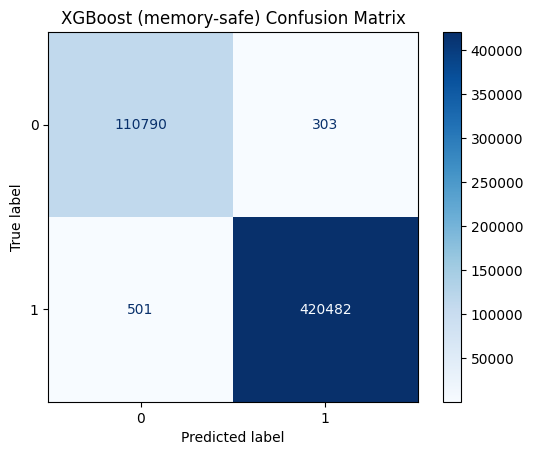

Model saved to: ../data/processed\xgb_model_memory_safe.json


In [14]:
xgb_model = train_xgb_memory_safe(X_train_s, y_train_enc, X_test_s, y_test_enc, DATA_DIR)
xgb_model.save_model(os.path.join(DATA_DIR, "xgb_model.json"))


REDUCE to 18 Features only

In [ ]:
# Single diagnostic + reducer cell
# Paste and run in a notebook cell. It will:
# 1) search for a folder that contains processed_train.csv
# 2) load processed_train.csv and processed_test.csv from that folder
# 3) extract the 18 features and save processed_reduced_train/test.csv in same folder
# 4) print progress and a small preview

import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split

FEATURE_ORDER = [
    "Flow Duration",
    "Total Fwd Packets",
    "Total Backward Packets",
    "Flow Packets/s",
    "Flow Bytes/s",
    "Min Packet Length",
    "Max Packet Length",
    "Packet Length Mean",
    "Packet Length Std",
    "Packet Length Variance",
    "Flow IAT Mean",
    "Flow IAT Std",
    "Flow IAT Max",
    "Flow IAT Min",
    "SYN Flag Count",
    "ACK Flag Count",
    "Fwd Packets/s",
    "Bwd Packets/s"
]

def _tolerant_column_match(df_columns, required_name):
    cols = list(df_columns)
    if required_name in cols:
        return required_name
    lowmap = {c.lower(): c for c in cols}
    key = required_name.lower()
    if key in lowmap:
        return lowmap[key]
    key_ns = key.replace(" ", "")
    simp_map = {c.lower().replace(" ", ""): c for c in cols}
    if key_ns in simp_map:
        return simp_map[key_ns]
    candidates = [c for c in cols if key in c.lower().replace(" ", "")]
    if candidates:
        return candidates[0]
    first_word = required_name.split()[0].lower()
    for c in cols:
        if first_word in c.lower():
            return c
    raise KeyError(f"Could not find a match for '{required_name}'. Sample cols: {cols[:30]}")

def extract_reduced_dataframe(df):
    label_col = None
    for c in df.columns:
        if 'label' in c.lower():
            label_col = c
            break
    if label_col is None:
        raise KeyError("No label column found in dataframe (looked for 'label' substring). Columns: " + ", ".join(list(df.columns)[:30]))
    mapping = {}
    for feat in FEATURE_ORDER:
        mapping[feat] = _tolerant_column_match(df.columns, feat)
    mapping['label'] = label_col
    reduced = df[[mapping[f] for f in FEATURE_ORDER] + [mapping['label']]].copy()
    reduced.columns = FEATURE_ORDER + ["label"]
    return reduced

# 1) Search for processed_train.csv in common locations (project tree)
search_roots = [os.getcwd(), os.path.expanduser("~")]
# also include repository root candidates (user workspace)
# walk only first 3 levels for speed
found_dir = None
for root in search_roots:
    for dirpath, dirnames, filenames in os.walk(root):
        if "processed_train.csv" in filenames and "processed_test.csv" in filenames:
            found_dir = dirpath
            break
        # limit recursion depth relative to root
        if dirpath.count(os.sep) - root.count(os.sep) > 3:
            dirnames[:] = []
    if found_dir:
        break

# If not found yet, try a broader search but limit results
if not found_dir:
    candidates = []
    for dirpath, dirnames, filenames in os.walk(os.getcwd()):
        if "processed_train.csv" in filenames:
            candidates.append(dirpath)
        if len(candidates) >= 6:
            break
    if candidates:
        print("Found candidate processed folders (first few):")
        for i,p in enumerate(candidates[:6]):
            print(f"[{i}] {p}")
        found_dir = candidates[0]
    else:
        print("No processed_train.csv found automatically. Please provide path to folder containing processed_train.csv and processed_test.csv.")
        # show current working directory and its contents for debugging
        print("Current working directory:", os.getcwd())
        print("Top-level files/dirs here:", os.listdir(os.getcwd())[:50])
        raise SystemExit("Cannot continue without processed_train.csv")

print("Using processed directory:", found_dir)

# 2) Load processed CSVs from found_dir
p_train = os.path.join(found_dir, "processed_train.csv")
p_test = os.path.join(found_dir, "processed_test.csv")
if not (os.path.exists(p_train) and os.path.exists(p_test)):
    print("One or both processed CSVs missing in:", found_dir)
    print("Exists processed_train.csv?", os.path.exists(p_train))
    print("Exists processed_test.csv?", os.path.exists(p_test))
    raise SystemExit("Required processed CSVs missing; stop.")

print("Loading processed_train.csv (this may take a moment)...")
train_df = pd.read_csv(p_train)
print("Loaded processed_train.csv with columns:", list(train_df.columns)[:40])

print("Loading processed_test.csv ...")
test_df = pd.read_csv(p_test)

# 3) Extract the 18 features (tolerant mapping)
print("Extracting the 18 selected features (tolerant matching)...")
try:
    train_reduced = extract_reduced_dataframe(train_df)
    test_reduced = extract_reduced_dataframe(test_df)
except Exception as e:
    print("Error mapping columns to required features:", e)
    # show columns to help debugging
    print("Sample columns from processed_train.csv:")
    for c in list(train_df.columns)[:80]:
        print("  ", c)
    raise

# 4) fill NaNs using train medians and save
medians = train_reduced[FEATURE_ORDER].median()
train_reduced[FEATURE_ORDER] = train_reduced[FEATURE_ORDER].fillna(medians).astype(float)
test_reduced[FEATURE_ORDER] = test_reduced[FEATURE_ORDER].fillna(medians).astype(float)

out_train = os.path.join(found_dir, "processed_reduced_train.csv")
out_test = os.path.join(found_dir, "processed_reduced_test.csv")
train_reduced.to_csv(out_train, index=False)
test_reduced.to_csv(out_test, index=False)

print("Saved reduced CSVs:")
print(" -", out_train)
print(" -", out_test)
print("\nPreview (train_reduced head):")
display(train_reduced.head())
print("Columns (order):", train_reduced.columns.tolist())


RF and XGB ReTrain on reduces data

In [ ]:
# === QUICK SAFE NOTEBOOK CELL (compatible with xgboost 3.1.1) ===
# Paste this into ONE notebook cell and run. Adjust file paths / SAMPLE_SIZE if needed.
import os, sys, time, warnings, joblib
# Force single-threading for native libs (important on Windows)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_MAX_THREADS'] = '1'
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

print("Python:", sys.version.splitlines()[0])
print("xgboost.__version__:", xgb.__version__)

# ---------- user-configurable ----------
import os
ROOT = os.path.abspath(os.path.join(os.path.dirname(__file__),".."))
DATA_DIR = os.path.join(ROOT,"data","processed")
TRAIN_PATH = os.path.join(DATA_DIR,"processed_reduced_train.csv")
TEST_PATH = os.path.join(DATA_DIR,"processed_reduced_test.csv")
RANDOM_STATE = 42
SAMPLE_SIZE = 50_000     # lower to 10k for even faster debug
RF_TUNE_ITERS = 8        # small randomized search
XGB_TUNE_ITERS = 8
CV_SPLITS = 3
FINAL_RF_TREES = 200     # small final RF for quick run
XGB_FINAL_EST = 200      # small XGB final n_estimators (no early stopping)
USE_GPU_FOR_XGB = False  # keep False (you have CUDA_HOME=None)
CHECKPOINT_DIR = Path.cwd()/"quick_checkpoints_xgb_compat"
CHECKPOINT_DIR.mkdir(exist_ok=True)
# ---------------------------------------

def detect_label_column(df):
    cand = ['label','Label','target','Target','y','Y','is_attack','attack','is_malicious','malicious']
    for c in cand:
        if c in df.columns: return c
    last = df.columns[-1]
    if df[last].nunique() <= 5: return last
    raise ValueError("Could not detect label column. Rename your target column to a known name.")

def safe_read(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        print(f"Warning: could not read {path}: {e}")
        return None

print("Loading data (quick)...")
df_train = safe_read(TRAIN_PATH)
df_test  = safe_read(TEST_PATH)

if df_train is None:
    print("Train CSV not found — generating tiny synthetic dataset for quick test.")
    n = 20000
    Xs = pd.DataFrame(np.random.randn(n, 12), columns=[f"f{i}" for i in range(12)])
    ys = (np.random.rand(n) > 0.98).astype(int)
    df_train = Xs.copy(); df_train['label'] = ys
if df_test is None:
    df_test = df_train.sample(frac=0.2, random_state=RANDOM_STATE).reset_index(drop=True)

label_col = detect_label_column(df_train)
print("Detected label column:", label_col)

has_test_label = label_col in df_test.columns
X_full = df_train.drop(columns=[label_col])
y_full = df_train[label_col].astype(int)
if has_test_label:
    X_test = df_test.drop(columns=[label_col])
    y_test = df_test[label_col].astype(int)
else:
    X_test = df_test.copy(); y_test = None

# train/val split (for threshold tuning)
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_full, y_full, test_size=0.15, stratify=y_full, random_state=RANDOM_STATE
)
print("Shapes: train_full", X_train_full.shape, "val", X_val.shape, "test", X_test.shape)

# downsample for quick tuning
if len(X_train_full) > SAMPLE_SIZE:
    X_tun, _, y_tun, _ = train_test_split(X_train_full, y_train_full, train_size=SAMPLE_SIZE,
                                          stratify=y_train_full, random_state=RANDOM_STATE)
else:
    X_tun, y_tun = X_train_full.copy(), y_train_full.copy()
print("Tuning sample:", X_tun.shape)

# simple preprocessing
numeric_cols = X_tun.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_tun.columns if c not in numeric_cols]
print("Numeric cols:", len(numeric_cols), "Cat cols:", len(cat_cols))

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preprocessor = ColumnTransformer([("num", numeric_transformer, numeric_cols),
                                  ("cat", categorical_transformer, cat_cols)],
                                 remainder='drop', verbose_feature_names_out=False)

# ---------- RandomForest quick tuning ----------
rf_pipe = Pipeline([("pre", preprocessor),
                    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced_subsample", n_jobs=1))])
rf_param_dist = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [6, 10, None],
    "clf__min_samples_split": [2, 4],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", 0.5]
}
print("Running small RandomForest RandomizedSearchCV...")
rf_search = RandomizedSearchCV(rf_pipe, rf_param_dist, n_iter=RF_TUNE_ITERS, scoring='f1',
                               cv=StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE),
                               verbose=1, n_jobs=1, random_state=RANDOM_STATE, return_train_score=False)
t0 = time.time()
rf_search.fit(X_tun, y_tun)
print("RF tuning time: {:.1f}s".format(time.time()-t0))
print("Best RF params:", rf_search.best_params_)
joblib.dump(rf_search.best_estimator_, CHECKPOINT_DIR/"rf_tuned_quick.joblib", compress=3)

# ---------- XGBoost quick tuning (no early stopping calls) ----------
# Use small n_estimators so training stays quick and compatible with xgboost 3.1.1
xgb_base = xgb.XGBClassifier(
    tree_method = "hist",
    predictor   = "cpu_predictor",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=1
)
xgb_pipe = Pipeline([("pre", preprocessor), ("clf", xgb_base)])
xgb_param_dist = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.3, 0.6, 1.0]
}
print("Running small XGBoost RandomizedSearchCV...")
xgb_search = RandomizedSearchCV(xgb_pipe, xgb_param_dist, n_iter=XGB_TUNE_ITERS, scoring='f1',
                                cv=StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE),
                                verbose=1, n_jobs=1, random_state=RANDOM_STATE, return_train_score=False)
t0 = time.time()
xgb_search.fit(X_tun, y_tun)
print("XGB tuning time: {:.1f}s".format(time.time()-t0))
print("Best XGB params:", xgb_search.best_params_)
joblib.dump(xgb_search.best_estimator_, CHECKPOINT_DIR/"xgb_tuned_quick.joblib", compress=3)

# ---------- quick final training: RF small final, XGB final (no callbacks) ----------
print("Training final RF (small trees)...")
best_rf_pipe = rf_search.best_estimator_
best_rf_pipe.named_steps['clf'].n_estimators = FINAL_RF_TREES
t0 = time.time()
best_rf_pipe.fit(X_train_full, y_train_full)
print("Final RF trained in {:.1f}s".format(time.time()-t0))
joblib.dump(best_rf_pipe, CHECKPOINT_DIR/"rf_final_quick.joblib", compress=3)

print("Training final XGB (CPU, fixed n_estimators) ...")
best_xgb_pipe = xgb_search.best_estimator_
# fit preprocessor and classifier without callbacks to be compatible with xgboost 3.1.1 wrapper
preproc = best_xgb_pipe.named_steps['pre']
clf = best_xgb_pipe.named_steps['clf']
preproc.fit(X_train_full)
Xtr = preproc.transform(X_train_full)
Xval_tr = preproc.transform(X_val)
clf.set_params(n_estimators=XGB_FINAL_EST, n_jobs=1, random_state=RANDOM_STATE)  # set small fixed n_estimators
t0 = time.time()
clf.fit(Xtr, y_train_full)   # no early stopping / callbacks
print("Final XGB trained in {:.1f}s".format(time.time()-t0))
xgb_final_pipe = Pipeline([("pre", preproc), ("clf", clf)])
joblib.dump(xgb_final_pipe, CHECKPOINT_DIR/"xgb_final_quick.joblib", compress=3)

# ---------- threshold tuning and ensemble ----------
def find_best_threshold(y_true, probs):
    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    f_scores = (2 * precision * recall) / (precision + recall + 1e-12)
    best_idx = np.nanargmax(f_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    return float(best_threshold), float(f_scores[best_idx])

# get val probs
probs_rf = best_rf_pipe.predict_proba(X_val)[:,1]
probs_xgb = xgb_final_pipe.predict_proba(X_val)[:,1]
thr_rf, f_rf = find_best_threshold(y_val, probs_rf)
thr_xgb, f_xgb = find_best_threshold(y_val, probs_xgb)
print(f"RF thr {thr_rf:.4f} (f1 {f_rf:.4f}), XGB thr {thr_xgb:.4f} (f1 {f_xgb:.4f})")

probs_avg_val = (probs_rf + probs_xgb) / 2.0
thr_avg, f_avg = find_best_threshold(y_val, probs_avg_val)
print(f"Avg ensemble thr {thr_avg:.4f} (f1 {f_avg:.4f})")

# stacking: small OOF on a subset for speed
def get_oof_preds(estimator, X, y, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof = np.zeros(len(X))
    for tr_idx, val_idx in skf.split(X, y):
        est = joblib.clone(estimator)
        est.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        oof[val_idx] = est.predict_proba(X.iloc[val_idx])[:,1]
    return oof

print("Generating small OOF preds for stacking (fast)...")
frac = 0.3 if len(X_train_full) > 1000 else 1.0
Xs_small = X_train_full.sample(frac=frac, random_state=RANDOM_STATE)
ys_small = y_train_full.loc[Xs_small.index]
oof_rf = get_oof_preds(best_rf_pipe, Xs_small, ys_small, n_splits=3)
oof_xgb = get_oof_preds(xgb_final_pipe, Xs_small, ys_small, n_splits=3)
X_level1 = np.vstack([oof_rf, oof_xgb]).T
meta = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
meta.fit(X_level1, ys_small.reset_index(drop=True))
val_level1 = np.vstack([probs_rf, probs_xgb]).T
probs_stack_val = meta.predict_proba(val_level1)[:,1]
thr_stack, f_stack = find_best_threshold(y_val, probs_stack_val)
print(f"Stack thr {thr_stack:.4f} (f1 {f_stack:.4f})")

# ---------- test evaluation (if labels present) ----------
if y_test is not None:
    print("Evaluating on test set...")
    probs_rf_test = best_rf_pipe.predict_proba(X_test)[:,1]
    probs_xgb_test = xgb_final_pipe.predict_proba(X_test)[:,1]
    probs_avg_test = (probs_rf_test + probs_xgb_test) / 2.0
    test_stack_feat = np.vstack([probs_rf_test, probs_xgb_test]).T
    probs_stack_test = meta.predict_proba(test_stack_feat)[:,1]
    def evalp(y_true, probs, thr):
        preds = (probs >= thr).astype(int)
        p,r,f,_ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
        auc = roc_auc_score(y_true, probs)
        return {'precision':p,'recall':r,'f1':f,'roc_auc':auc}
    res = {'rf':evalp(y_test, probs_rf_test, thr_rf),
           'xgb':evalp(y_test, probs_xgb_test, thr_xgb),
           'avg':evalp(y_test, probs_avg_test, thr_avg),
           'stack':evalp(y_test, probs_stack_test, thr_stack)}
    for k,v in res.items(): print(k, v)
else:
    print("No test labels present; saved models for later prediction.")

# ---------- save ensemble wrapper ----------
class EnsembleWrapper:
    def __init__(self, rf, xgb, meta, thr_rf, thr_xgb, thr_avg, thr_stack):
        self.rf = rf; self.xgb = xgb; self.meta = meta
        self.thr_rf = thr_rf; self.thr_xgb = thr_xgb
        self.thr_avg = thr_avg; self.thr_stack = thr_stack
    def predict_proba(self, X):
        prf = self.rf.predict_proba(X)[:,1]; px = self.xgb.predict_proba(X)[:,1]
        return {'rf':prf,'xgb':px,'avg':(prf+px)/2.0,'stack':self.meta.predict_proba(np.vstack([prf,px]).T)[:,1]}
    def predict(self, X, method="stack"):
        probs = self.predict_proba(X)[method]
        thr = {'rf':self.thr_rf,'xgb':self.thr_xgb,'avg':self.thr_avg,'stack':self.thr_stack}[method]
        return (probs >= thr).astype(int)

ensemble = EnsembleWrapper(best_rf_pipe, xgb_final_pipe, meta, thr_rf, thr_xgb, thr_avg, thr_stack)
joblib.dump(ensemble, CHECKPOINT_DIR/"ensemble_quick_xgb_compat.joblib", compress=3)
print("Quick run complete. Checkpoints saved to:", CHECKPOINT_DIR)


In [ ]:
# Notebook Header: force single-threading and show system info (run first)
import os, sys, platform, psutil, warnings
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_MAX_THREADS'] = '1'
warnings.filterwarnings("ignore")
print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
try:
    print("RAM (GB):", round(psutil.virtual_memory().total/1024**3,2), "Cores:", psutil.cpu_count(logical=True))
except Exception:
    pass

# quick synthetic sanity test (uncomment to run a tiny fit)
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np
# X = np.random.randn(2000,10); y = (np.random.rand(2000) > 0.95).astype(int)
# rf = RandomForestClassifier(n_estimators=10, n_jobs=1)
# rf.fit(X,y)
# print("Sanity RF fit OK")


🔍 Checking GPU availability...

🟩 NVIDIA GPU detected by OS:
Fri Nov 14 12:02:06 2025       

⚠️ PyTorch not installed — skipping PyTorch CUDA check.

🔧 Checking XGBoost GPU support ('gpu_hist')...
❌ XGBoost GPU mode NOT available.
Reason: [12:02:07] C:\actions-runner\_work\xgboost\xgboost\src\context.cc:242: `gpu_id` has been removed since 3.1. Use `device` instead.

================== GPU SUMMARY ==================
GPU visible via nvidia-smi  : True
XGBoost GPU (gpu_hist)      : False
CUDA available (PyTorch)    : unknown

⚠️ WARNING: XGBoost will fall back to CPU mode.


In [ ]:
# Tiny XGB sanity test using callback-style early stopping (works with xgboost 3.1.1)
import os, time, traceback
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_MAX_THREADS'] = '1'

import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

print("xgboost.__version__:", xgb.__version__)
X = np.random.randn(2000, 10)
y = (np.random.rand(2000) > 0.98).astype(int)

print("Fitting small RandomForest (n_jobs=1)...")
rf = RandomForestClassifier(n_estimators=30, n_jobs=1, random_state=42)
t0 = time.time(); rf.fit(X, y); print("RF done in %.2fs" % (time.time()-t0))

print("Fitting small XGBoost (CPU) using callback early stopping...")
xgb_clf = xgb.XGBClassifier(tree_method='hist', predictor='cpu_predictor',
                            n_estimators=200, use_label_encoder=False, eval_metric='logloss', n_jobs=1, random_state=42)
t0 = time.time()
xgb_clf.fit(X, y, eval_set=[(X, y)], callbacks=[xgb.callback.EarlyStopping(rounds=10, save_best=True)])
print("XGB done in %.2fs" % (time.time()-t0))

print("Sanity test PASSED (callback-based early stopping worked).")


In [ ]:
import xgboost as xgb, numpy as np
d = xgb.DMatrix(np.random.rand(1000,10), label=np.random.rand(1000))
bst = xgb.train({
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "device": "cuda:0"
}, d, num_boost_round=5)
print("GPU test done")